# Support Tensor Machine

In [1]:
import cvxpy
import numpy as np

## Motivation

**Support Vector Machine** (SVM) is a well-known supervised learning model introduced by Vapnik in
1995 for solving two-class pattern recognition problem. 

SVM is used in text categorization, image classification, spam filters and also in many other classification problems.

## Recap: SVM

<span style="color:red">(здесь нужно сказать, что SVM был у нас на лекциях, поэтому мы просто напомним как ставится задача оптимизации и пойдем дальше)</span>

Before we start, let's recall how SVM looks like

$$
\begin{align}
\min_{u, b, \xi}&\;\; \frac{1}{2} \|u\|_2^2 + C \mathbf{1}^\top \xi\\
s.t.\;& y_i (u^\top x_i + b) \ge 1-\xi_i,\\
    &\xi \succeq 0
\end{align}
$$
We can solve this using CVXPY

In [2]:
def svm_cvx(x, y, c, beta=1.):
    # weights for optimization
    w = cvxpy.Variable((x.shape[1], ))
    # xi for each element in x
    eps = cvxpy.Variable((x.shape[0], ), nonneg=True)
    # bias
    b = cvxpy.Variable()
    if w.is_scalar():  # a corner case, when vector of length 1 is treated as scalar
        wrt = cvxpy.multiply(y, (x * w)[:, 0] + b) >= (1-eps)
    else:
        wrt = cvxpy.multiply(y, x @ w + b) >= (1-eps)
    # and finally an objective with constraints
    problem = cvxpy.Problem(
        cvxpy.Minimize(0.5 * beta * cvxpy.norm(w) ** 2 + c * cvxpy.sum(eps)), 
        [wrt]
    )
    problem.solve()
    # we only have to know w, b to make predictions
    return w.value, b.value

def predict(x, w, b):
    return np.sign(x @ w + b)

### Synthetic dataset


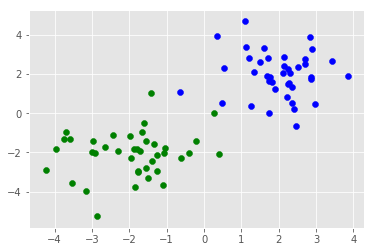

In [3]:
x1 = np.random.normal(2, 1, (40, 2))
x2 = np.random.normal(-2, 1, (40, 2))
plt.scatter(x1[:, 0], x1[:, 1], color='blue')
plt.scatter(x2[:, 0], x2[:, 1], color='green')

Train SVM using CVXPY

In [4]:
w, b = svm_cvx(
    # data
    np.concatenate([x1, x2]), 
    # targets
    np.concatenate([np.ones(x1.shape[0]), -np.ones(x1.shape[0])]), 
    # iterations
    10
)

What are the estimates?

In [5]:
w, b

(array([2.2099394 , 3.82191392]), array(-1.69064593))

Let's now plot the solution border

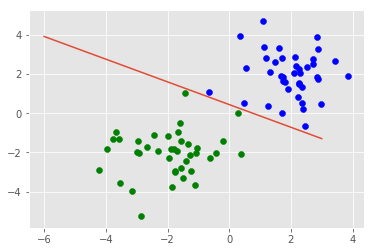

In [6]:
plt.scatter(x1[:, 0], x1[:, 1], color='blue')
plt.scatter(x2[:, 0], x2[:, 1], color='green')
x = np.arange(-6, 4)
y = -(w[0] * x + b) / w[1]
plt.plot(x, y)

... and check all is good with predictions

In [7]:
predict(x1, w, b)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

In [8]:
predict(x2, w, b)

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1.])

<span style="color:red">(здесь нужно сказать, что мы(Максим) написали SVM не просто так, а он нам понадобится еще в дальнейшем)</span>

## Support Tensor Machine

In SVM model each data point is a $n$-dimentional vector.

In supervised learning settings with many input features, overfitting is usually a potential problem
unless there is ample training data. And it is well known that for unregularized
discriminative models fit via training-error minimization, sample complexity (i.e., the number of
training examples needed to overfit) grows about linearly in the number of
parameters, which grows linearly in this model in the number of input features.

So, these reasons lead us to consider new representations and corresponding learning algorithms with less
number of parameters.

A linear classifier in $\mathbb{R}^n$ can be represented as $a^\top x + b$ in which there are $n + 1 \ (\approx n_1 \times n_2 + 1)$
parameters $(b, a_i,\ i = 1, \dots , n)$. 

Similarly, a linear classifier in the $\mathbb{R}^{n_1} \otimes \mathbb{R}^{n_2}$ tensor space can be represented as $u^\top X v + b$ where $u \in \mathbb{R}^{n_1}$ and $v \in \mathbb{R}^{n_2}$. Thus, there are only $n_1 +n_2 + 1$ parameters.

## Support Tensor Machine

In **Support Tensor Machine** (STM) we convert vector $x \in \mathbb{R}^n$ in second order tensor (or matrix) $X \in \mathbb{R}^{n_1} \otimes \mathbb{R}^{n_2}$ (we consider two dimentional case), where $n_1 \times n_2 \approx n$.

### The Problem

Given a set of training samples $\{X_i, y_i\}$, $i = 1, \dots , m$, where $X_i$ is the data point in order-$2$ tensor space, $X_i \in \mathbb{R}^{n_1} \otimes \mathbb{R}^{n_2}$ and $y_i \in \{−1, 1\}$ is the label associated with $X_i$. Find a tensor classifier $f(X) = u^\top X v + b$ such that the two classes can be separated with maximum margin.

This idea was presented by [Deng Cai et al, 2006](https://www.ideals.illinois.edu/bitstream/handle/2142/11193/Support%20Tensor%20Machines%20for%20Text%20Categorization.pdf?sequence=2). 

And the idea of tensorization of algorithms was also used in Principal Component Analysis ([Deng Cai et al, 2006](https://www.ideals.illinois.edu/bitstream/handle/2142/11195/Learning%20with%20Tensor%20Representation.pdf?sequence=2)), Linear Discriminant Analysis ([Xiaofei He et al, 2005](http://www.cad.zju.edu.cn/home/dengcai/Publication/Conference/2005_NIPS_TSA.pdf)), and Locality Preserving Projection ([Jieping Ye et al, 2004](https://papers.nips.cc/paper/2547-two-dimensional-linear-discriminant-analysis.pdf))

## The Algorithm

**Support Tensor Machine** does not differ too much from SVM. It just adds an iterative method to fund a solution in a tensor space

**Step 0**
initialize $b=0$, $u=\mathbf1$, $v=\mathbf1$

**Step % 2 == 0**
$$
\begin{align}
\beta_1 &= \|v\|_2^2\\
\tilde{x} &= Xv\\
\min_{u, b, \xi}&\;\; \frac{1}{2} \beta_1\|u\|_2^2 + C \mathbf{1}^\top \xi\\
s.t.\;& y_i (u^\top \tilde{x}_i + b) \ge 1-\xi_i,\\
    &\xi \succeq 0
\end{align}
$$
save $b$, $u$ for next iterations

**Step % 2 == 1**
$$
\begin{align}
\beta &= \|u\|_2^2\\
\tilde{x} &= u^\top X\\
\min_{v, b, \xi}&\;\; \frac{1}{2} \beta_2\|v\|_2^2 + C \mathbf{1}^\top \xi\\
s.t.\;& y_i (v^\top \tilde{x}_i + b) \ge 1-\xi_i,\\
    &\xi \succeq 0
\end{align}
$$
save $b$, $v$ for next iterations


**Iteratively computing $u$ and $v$ until they tend to converge.**

In [43]:
def stm_cvx(X, y, c, numiter=10, tolerance=1e-4):
    u, v, b = np.ones(X.shape[-2]), np.ones(X.shape[-1]), 1
    uo, vo = u, v
    for i in range(numiter*2):
        if i % 2 == 0:
            x = X @ v
            beta = np.linalg.norm(v)
            u, b = svm_cvx(x, y, c, beta)
        else:
            x = X.transpose(0, 2, 1) @ u
            beta = np.linalg.norm(u)
            v, b = svm_cvx(x, y, c, beta)
        if i > 0 and i % 2:
            if ( # check u
                (np.linalg.norm(uo-u)/np.linalg.norm(uo)) < tolerance 
                and
                 # check v
                (np.linalg.norm(vo-v)/np.linalg.norm(vo)) < tolerance
               ):
                break
            else:
                uo, vo = u, v
    return u, v, b

def predict_stm(X, u, v, b):
    return np.sign((X.transpose(0, 2, 1) @ u) @ v + b)

Test STM on the same dataset, we should get the same good result

In [10]:
np.concatenate([x1, x2])[..., None].shape

(80, 2, 1)

In [11]:
u, v, b = stm_cvx(
    np.concatenate([x1, x2])[..., None], 
    np.concatenate([np.ones(x1.shape[0]), -np.ones(x1.shape[0])]), 
    10)

Looks nice

In [12]:
predict_stm(np.concatenate([x1, x2])[..., None], u, v, b)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1.])

## Larger dataset for STM

Now we apply STM model for text categorization.

Each document can be presented as a vector and each word in the document corresponds to a dimension.

We use term frequency–inverse document frequency statistic to vectorize documents.

In [46]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
cats = ['alt.atheism', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train', categories=cats)
newsgroups_test = fetch_20newsgroups(subset='test', categories=cats)
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors_test = vectorizer.transform(newsgroups_test.data)

First, we try SVM

In [30]:
from sklearn.svm import SVC
from sklearn import metrics
clf = SVC(gamma='auto', kernel='linear')
clf.fit(vectors, newsgroups_train.target)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [31]:
metrics.f1_score(newsgroups_test.target, clf.predict(vectors_test), average='macro')

0.9758050833078828

### Data preparation
We need to prepare incoming data and pack it into tensor format. In here we sort features by their variance. Varying features go first, constant last

In [48]:
np.arange(10).reshape(5, 2)

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

In [71]:
from sklearn.base import TransformerMixin
import scipy.sparse
class Tensorize(TransformerMixin):
    """
    implements sorting approach to tensorization
    """
    def __init__(self, k, m=None):
        self.k = k
        self.m = m
        self.order = None

    def fit(self, x, y=None):
        if self.m is None:
            self.m = x.shape[1] // self.k + bool(x.shape[1] % self.k)
        assert x.shape[1] <= self.k * self.m
        if scipy.sparse.issparse(x):
            x = x.toarray()
        agg = np.var(x, 0)
        self.order = np.argsort(agg)[::-1]
        return self

    def transform(self, x, y=None):
        xh = np.zeros((x.shape[0], self.k*self.m))
        if scipy.sparse.issparse(x):
            x = x.toarray()
        xh[:, :x.shape[1]] = x[:, self.order]
        return xh.reshape(x.shape[0], self.k, self.m)

What is the size of incoming data?

In [72]:
vectors.shape

(1073, 22464)

Look at the variance of unsorted data, it is quite unstructured

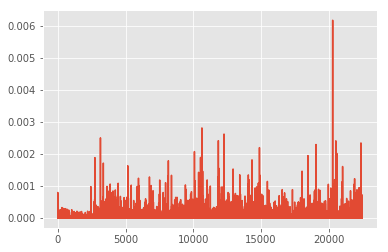

In [73]:
plt.plot(scipy.var(vectors.toarray(), 0))

Now we prepare tensor and pack groups of 10. Most varying features are first, less varying next. Range reshaping will illustrate the order

In [82]:
np.arange(12).reshape(3, -1)

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [84]:
tensorize = Tensorize(100)
tens = tensorize.fit_transform(vectors)
tens_test = tensorize.transform(vectors_test)

In [85]:
tensorize.k, tensorize.m

(100, 225)

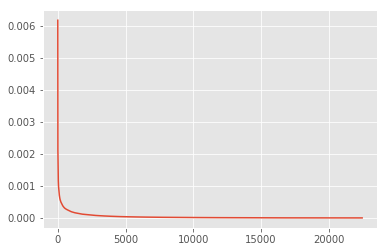

In [86]:
plt.plot(scipy.var(vectors.toarray(), 0)[tensorize.order])

In [87]:
from sklearn.base import ClassifierMixin
class STM(ClassifierMixin):
    def __init__(self, numiter=10, c=1, tol=1e-4):
        self.u = None
        self.v = None
        self.b = None
        self.numiter = numiter
        self.c = c
        self.tol = tol

    def fit(self, X, y):
        assert np.allclose(np.unique(y), np.arange(2))
        assert len(X.shape) == 3
        y = y.copy()
        y[y==0] = -1
        self.u, self.v, self.b = stm_cvx(X, y, self.c, self.numiter, tolerance=self.tol)
        return self
    
    def predict(self, X):
        y = predict_stm(X, self.u, self.v, self.b)
        y[y==-1] = 0
        return y


In [88]:
stm = STM(numiter=10)

In [89]:
tens.shape

(1073, 100, 225)

In [90]:
stm.fit(tens, newsgroups_train.target)

Roughly the same as svm

In [91]:
metrics.f1_score(newsgroups_test.target, stm.predict(tens_test), average='macro')

0.9311864624887403

Can we make better? We can try larger/smaller partition group

In [92]:
# try tensorize with partition 10, 50, 100, 150, 200 and please plot partition vs f1 score for this grid

## Conclusion 

<span style="color:red">(здесь нужно сказать, что STM работает почти также как SVM, но на маленьких датасетах STM работает лучше)</span>